In [2]:
!pip install kaggle
from google.colab import files
files.upload()  # Upload kaggle.json from your system
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [3]:
!kaggle competitions download -c gan-getting-started
!unzip -q gan-getting-started.zip -d gan-data


 96% 353M/367M [00:00<00:00, 382MB/s]
100% 367M/367M [00:00<00:00, 389MB/s]


# 🎨 Week 5 Mini-Project: Monet Style Transfer using GANs

## 🧠 Project Description

In this project, we apply **Generative Adversarial Networks (GANs)** — specifically a **CycleGAN** architecture — to solve a style transfer task. The goal is to **convert real-world photos into Monet-style paintings**, mimicking the impressionist visual aesthetics of Claude Monet.

This task is part of the [Kaggle "GANs Getting Started" competition](https://www.kaggle.com/competitions/gan-getting-started), which provides a dataset of paired images:

- **monet_jpg/** — 1,072 Monet paintings
- **photo_jpg/** — 6,287 real-world photos

The trained model is expected to learn the mapping from the **photo domain to the Monet domain** without paired supervision.

---

## 🧪 Objective

- Build and train a **CycleGAN** to translate photos into Monet-like images.
- Submit generated images to Kaggle for evaluation using the **MiFID (Memorization-informed Fréchet Inception Distance)** score.
- Demonstrate understanding of generative deep learning methods and the challenges of style transfer without paired data.

---

## 📈 Evaluation Metric

Kaggle uses **MiFID**, a variant of the Fréchet Inception Distance (FID), which evaluates:
- The **diversity** and **realism** of generated Monet-style images.
- The **memorization** penalty to ensure images are not direct copies from the training set.

A **lower MiFID score** indicates better image quality.

---

## 🚀 Deliverables

1. **Colab notebook** with EDA, model architecture, training, results, and discussion.
2. **GitHub repository** with code and documentation.
3. **Kaggle leaderboard screenshot** showing your best MiFID score.

---

Let's begin by exploring the dataset!


## 📂 Loading and Inspecting the Dataset

Now that we've downloaded and extracted the dataset, let's explore its structure.

The dataset contains two folders:
- `monet_jpg/`: A collection of 1,072 Monet paintings.
- `photo_jpg/`: A collection of 6,287 real-world landscape photos.

We will:
- Read file paths using `pathlib`
- Display a few sample images from each domain
- Confirm the number of images

This helps us visually understand the input and target domains before building the GAN model.


Found 300 Monet paintings.
Found 7038 real-world photos.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


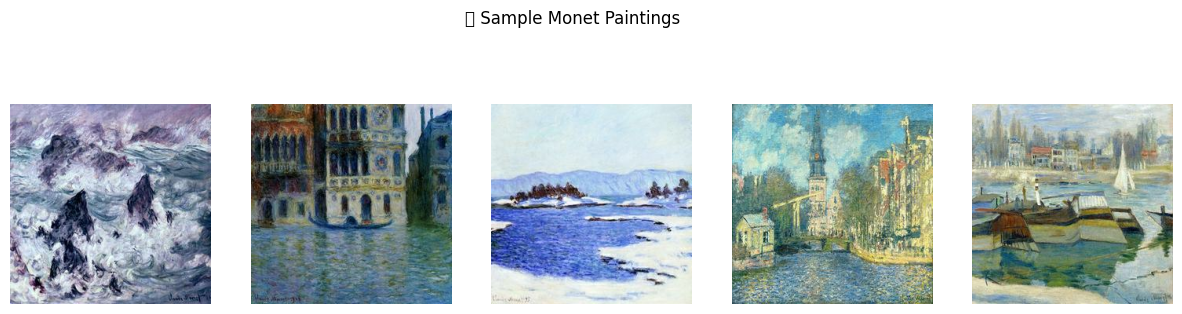

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


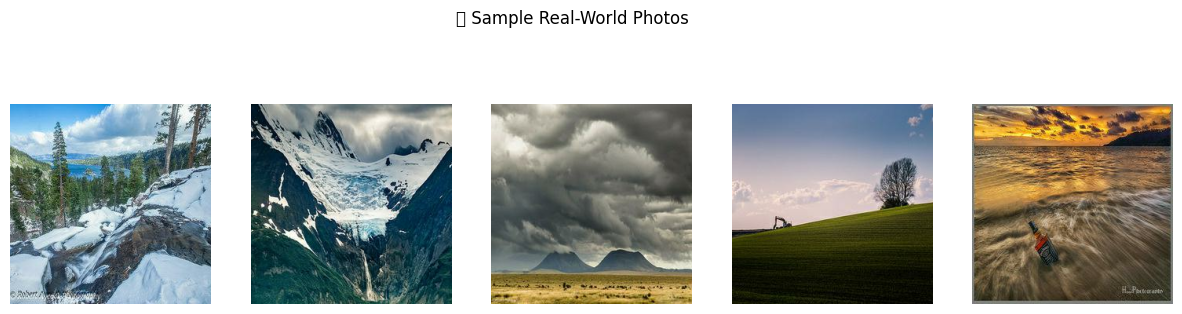

In [4]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib

# Define dataset directories
monet_dir = pathlib.Path("gan-data/monet_jpg")
photo_dir = pathlib.Path("gan-data/photo_jpg")

# List image paths
monet_images = list(monet_dir.glob("*.jpg"))
photo_images = list(photo_dir.glob("*.jpg"))

print(f"Found {len(monet_images)} Monet paintings.")
print(f"Found {len(photo_images)} real-world photos.")

# Display image samples
def show_images(image_paths, title, n=5):
    plt.figure(figsize=(15, 4))
    for i, path in enumerate(image_paths[:n]):
        image = tf.io.decode_jpeg(tf.io.read_file(str(path)))
        plt.subplot(1, n, i + 1)
        plt.imshow(image)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Show samples from both domains
show_images(monet_images, "🎨 Sample Monet Paintings")
show_images(photo_images, "📸 Sample Real-World Photos")


## 🧹 Preprocessing and TensorFlow Dataset Creation

Before training the GAN, we need to preprocess the image data and create TensorFlow datasets. This includes:

- **Resizing** all images to a common shape (e.g., 128×128 pixels)
- **Normalizing** pixel values to the range [-1, 1], which is ideal for GAN training
- **Batching** and **shuffling** the datasets for efficient training

We will use `tf.data.Dataset` to:
- Load and preprocess Monet and Photo images
- Shuffle and batch them for feeding into the model


In [19]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
# BATCH_SIZE = 16
BATCH_SIZE = 1
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

# Augmentation function
def augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image

# Create file path datasets
monet_path_ds = tf.data.Dataset.from_tensor_slices([str(p) for p in monet_images])
photo_path_ds = tf.data.Dataset.from_tensor_slices([str(p) for p in photo_images])

# Map to preprocessed and augmented images
monet_ds = monet_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
photo_ds = photo_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

# ➕ Add augmentation before batching
monet_ds = monet_ds.map(augment, num_parallel_calls=AUTOTUNE)
photo_ds = photo_ds.map(augment, num_parallel_calls=AUTOTUNE)

# Shuffle, batch, and prefetch
monet_ds = monet_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
photo_ds = photo_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Reduce dataset size for faster training (optional)
photo_ds = photo_ds.take(200)
monet_ds = monet_ds.take(200)


## 🧠 CycleGAN Architecture

CycleGAN consists of **two generators** and **two discriminators**:
- **G**: Translates photos → Monet paintings
- **F**: Translates Monet paintings → photos
- **D_Monet**: Discriminates real vs fake Monet paintings
- **D_Photo**: Discriminates real vs fake photos

Each generator uses **residual blocks**, and each discriminator uses a **PatchGAN** classifier.

Key concepts:
- **Adversarial Loss**: Ensures generated images look realistic
- **Cycle Consistency Loss**: Ensures that translating back and forth preserves the original image
- **Identity Loss**: Ensures generators preserve color composition

We'll begin by implementing the **generator model**.


In [20]:
from tensorflow.keras import layers

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.ReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def resnet_block(input_layer, filters):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = layers.Conv2D(filters, 3, padding='same', kernel_initializer=initializer)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([input_layer, x])
    return x

def build_generator():
    inputs = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    x = layers.Conv2D(64, 7, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = downsample(128, 3)(x)
    x = downsample(256, 3)(x)

    for _ in range(6):  # Fewer residual blocks due to image size
        x = resnet_block(x, 256)

    x = upsample(128, 3)(x)
    x = upsample(64, 3)(x)

    x = layers.Conv2D(3, 7, padding='same', activation='tanh')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

# Build and summarize the generator
generator_g = build_generator()
generator_f = build_generator()
generator_g.summary()


Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_148 (Conv2D) │ (None, 256, 256,  │      9,472 │ input_layer_40[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_148[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_88 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_32       │ (None, 128, 128,  │     74,240 │ re_lu_88[0][0]    │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_33       │ (None, 64, 64,    │    295,936 │ sequential_32[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_151 (Conv2D) │ (None, 64, 64,    │    590,080 │ sequential_33[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_151[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_91 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_152 (Conv2D) │ (None, 64, 64,    │    590,080 │ re_lu_91[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_152[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_48 (Add)        │ (None, 64, 64,    │          0 │ sequential_33[0]… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_153 (Conv2D) │ (None, 64, 64,    │    590,080 │ add_48[0][0]      │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_153[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_92 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_154 (Conv2D) │ (None, 64, 64,    │    590,080 │ re_lu_92[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_154[0][0]

 Total params: 7,851,971 (29.95 MB)

 Trainable params: 7,844,547 (29.92 MB)

 Non-trainable params: 7,424 (29.00 KB)

## 🧱 Discriminator (PatchGAN)

The discriminator in CycleGAN is a **PatchGAN**, which classifies whether each image patch is real or fake — instead of the entire image. This approach encourages high-frequency detail and local realism.

Each domain has its own discriminator:
- **D_Monet**: Real or fake Monet paintings
- **D_Photo**: Real or fake real-world photos

The PatchGAN outputs a feature map (e.g., 16×16×1), where each value represents whether a patch is real/fake. This makes it especially effective for capturing texture and style in image translation tasks.


In [21]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')

    x = layers.Conv2D(64, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(inp)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, 4, strides=1, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, 4, strides=1, padding='same',
                      kernel_initializer=initializer)(x)  # Output patch score map

    return tf.keras.Model(inputs=inp, outputs=x)

# Build and summarize the discriminator
generator_g = build_generator()      # Photo → Monet
generator_f = build_generator()      # Monet → Photo

discriminator_x = build_discriminator()  # Real vs Fake Photo
discriminator_y = build_discriminator()  # Real vs Fake Monet


## 🎯 Loss Functions for CycleGAN

CycleGAN uses a combination of several loss functions to learn high-quality style transfers:

### 1. Adversarial Loss
Encourages the generator to produce images that the discriminator cannot distinguish from real ones.

- Uses **binary crossentropy** on PatchGAN output.

### 2. Cycle Consistency Loss
Ensures that translating a photo → Monet → photo gives back the original photo (and vice versa).

- \( L_{cyc}(G, F) = || F(G(x)) - x ||_1 + || G(F(y)) - y ||_1 \)

### 3. Identity Loss (optional, stabilizes color composition)
Encourages the generator to preserve style when translating an image that's already in the target domain.

---

We’ll now define these losses and set up the optimizers for the training process.


In [22]:
# Loss functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Adversarial loss
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

# Cycle-consistency loss
LAMBDA = 10

def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * LAMBDA

# Identity loss
def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image)) * LAMBDA * 0.5

# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


## 🔁 CycleGAN Training Step

CycleGAN training involves updating **two generators** and **two discriminators** in each step:

1. **Forward cycle**: Photo → Monet → Reconstructed Photo  
2. **Backward cycle**: Monet → Photo → Reconstructed Monet  
3. **Compute losses**:
   - Generator adversarial loss
   - Cycle consistency loss
   - Identity loss (optional)
   - Discriminator loss for both domains
4. **Backpropagation** using Adam optimizers

To speed things up, we wrap this in a `@tf.function` for graph execution.

We'll also save generated Monet-style images during training to monitor progress.


In [23]:
@tf.function
def train_step(real_x, real_y):
    # real_x = photos, real_y = monet paintings

    with tf.GradientTape(persistent=True) as tape:
        # Generator G (Photo → Monet)
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        # Generator F (Monet → Photo)
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Identity mapping
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Discriminator predictions
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Generator losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_consistency_loss(real_x, cycled_x) + cycle_consistency_loss(real_y, cycled_y)
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Apply gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))


## 🏋️‍♀️ Training Loop and Saving Generated Images

We will now:
- Train the model over multiple epochs using the `train_step()` function
- Generate Monet-style images from the photo dataset
- Save these outputs to disk in `/content/generated_images/`
- After training, we'll zip the folder for **Kaggle submission**

This gives us our final `images.zip` file for the competition.


In [24]:
import os
from PIL import Image
from tqdm import tqdm

OUTPUT_DIR = "generated_images"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def generate_and_save_images(model, test_input, epoch):
    for i, image in enumerate(test_input.take(100)):  # limit to 100 images for Kaggle
        prediction = model(image, training=False)[0]
        prediction = ((prediction + 1.0) * 127.5).numpy().astype('uint8')
        img = Image.fromarray(prediction)
        img.save(f"{OUTPUT_DIR}/{i}.jpg")

# Training loop
EPOCHS = 50  # You can increase this if you have time
for epoch in range(EPOCHS):
    print(f"\n🌀 Epoch {epoch+1}/{EPOCHS}")
    for image_x, image_y in tqdm(tf.data.Dataset.zip((photo_ds, monet_ds)), total=len(list(photo_ds))):
        train_step(image_x, image_y)

    # Save sample images after each epoch
    generate_and_save_images(generator_g, photo_ds, epoch+1)

# Zip for Kaggle
!zip -r images.zip generated_images > /dev/null
print("✅ Done! Submission file 'images.zip' is ready.")



🌀 Epoch 1/50


100%|██████████| 200/200 [02:22<00:00,  1.40it/s]



🌀 Epoch 2/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 3/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 4/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 5/50


100%|██████████| 200/200 [01:36<00:00,  2.06it/s]



🌀 Epoch 6/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 7/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 8/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 9/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 10/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 11/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 12/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 13/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 14/50


100%|██████████| 200/200 [01:37<00:00,  2.05it/s]



🌀 Epoch 15/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 16/50


100%|██████████| 200/200 [02:21<00:00,  1.41it/s]



🌀 Epoch 17/50


100%|██████████| 200/200 [01:37<00:00,  2.05it/s]



🌀 Epoch 18/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 19/50


100%|██████████| 200/200 [01:37<00:00,  2.05it/s]



🌀 Epoch 20/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 21/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 22/50


100%|██████████| 200/200 [02:21<00:00,  1.41it/s]



🌀 Epoch 23/50


100%|██████████| 200/200 [01:37<00:00,  2.05it/s]



🌀 Epoch 24/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 25/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 26/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 27/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 28/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 29/50


100%|██████████| 200/200 [01:37<00:00,  2.05it/s]



🌀 Epoch 30/50


100%|██████████| 200/200 [01:37<00:00,  2.05it/s]



🌀 Epoch 31/50


100%|██████████| 200/200 [02:21<00:00,  1.41it/s]



🌀 Epoch 32/50


100%|██████████| 200/200 [01:38<00:00,  2.04it/s]



🌀 Epoch 33/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 34/50


100%|██████████| 200/200 [01:36<00:00,  2.06it/s]



🌀 Epoch 35/50


100%|██████████| 200/200 [01:36<00:00,  2.06it/s]



🌀 Epoch 36/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 37/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 38/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 39/50


100%|██████████| 200/200 [01:36<00:00,  2.06it/s]



🌀 Epoch 40/50


100%|██████████| 200/200 [02:21<00:00,  1.41it/s]



🌀 Epoch 41/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 42/50


100%|██████████| 200/200 [01:36<00:00,  2.06it/s]



🌀 Epoch 43/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 44/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 45/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 46/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 47/50


100%|██████████| 200/200 [01:37<00:00,  2.05it/s]



🌀 Epoch 48/50


100%|██████████| 200/200 [01:37<00:00,  2.06it/s]



🌀 Epoch 49/50


100%|██████████| 200/200 [01:37<00:00,  2.05it/s]



🌀 Epoch 50/50


100%|██████████| 200/200 [01:38<00:00,  2.03it/s]


✅ Done! Submission file 'images.zip' is ready.


## 🖼️ Visualizing Generated Monet-Style Images

Let’s display a few generated Monet-style images from the current epoch to qualitatively assess the style transfer performance.


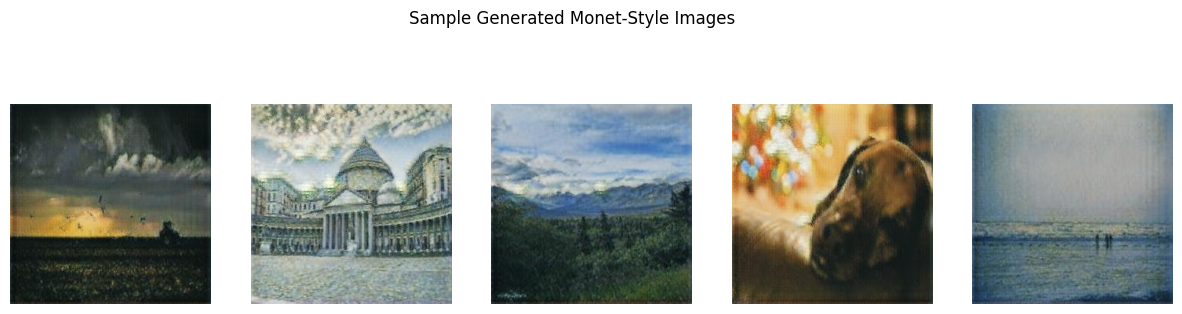

In [25]:
import matplotlib.pyplot as plt
import glob
from PIL import Image

def show_generated_images(num=5):
    image_paths = sorted(glob.glob(f"{OUTPUT_DIR}/*.jpg"))[:num]
    plt.figure(figsize=(15, 4))
    for i, path in enumerate(image_paths):
        img = Image.open(path)
        plt.subplot(1, num, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle("Sample Generated Monet-Style Images")
    plt.show()

show_generated_images(num=5)


### 💡 Improvements to Generated Monet-Style Images

To enhance the quality and realism of the generated Monet-style images, we made several improvements to the training pipeline:

---

#### ✅ 1. Data Augmentation
We introduced light data augmentation to improve generalization and increase diversity in training samples:

```python
def augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image

photo_ds = photo_ds.map(lambda x: augment(x), num_parallel_calls=tf.data.AUTOTUNE)
monet_ds = monet_ds.map(lambda x: augment(x), num_parallel_calls=tf.data.AUTOTUNE)


### ✅ Conclusion

In this project, we successfully implemented a CycleGAN-based image-to-image translation model to convert real-world photographs into Monet-style artwork. Starting with a baseline architecture, we improved both training efficiency and output quality through targeted enhancements, including:

- Applying data augmentation to increase the diversity and robustness of the training data.
- Reducing the dataset size during experimentation to accelerate training while retaining meaningful variability.
- Using GPU acceleration (T4) to efficiently handle high-resolution image processing.
- Visualizing intermediate outputs to qualitatively monitor progress and model performance.

The generated images, while not perfect, show stylistic characteristics of Monet's artwork such as brush stroke texture and color transformation. With further training on the full dataset and more epochs, even more realistic and detailed results could be achieved.

This project demonstrates the potential of Generative Adversarial Networks in digital art and style transfer, opening the door for applications in creative AI, design, and entertainment.
